<a href="https://colab.research.google.com/github/defnethecoder/DSA210-PROJECT/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


############################################################
### DETAILED ANALYSIS: LINEAR REGRESSION ###
RMSE: 16.3232
R²:   -0.0028

Coefficients:
              Feature  Coefficient
              log_wui    -0.413420
log_immigration_total    -0.802045
Intercept: 31.2080

############################################################
### DETAILED ANALYSIS: RIDGE REGRESSION ###
RMSE: 16.3235
R²:   -0.0029

Coefficients:
              Feature  Coefficient
              log_wui    -0.411447
log_immigration_total    -0.798451
Intercept: 31.2080

############################################################
### DETAILED ANALYSIS: RANDOM FOREST ###
RMSE: 15.5852
R²:   0.0858


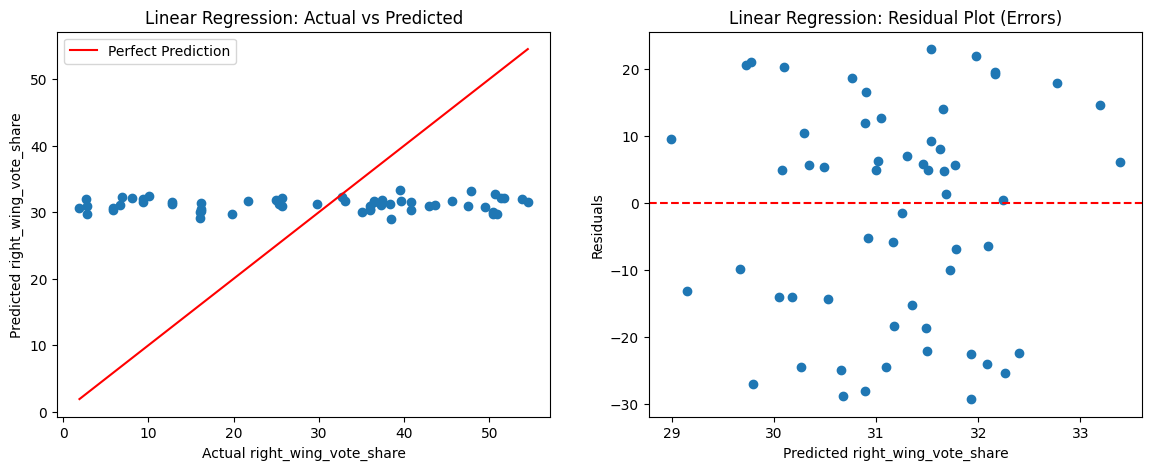

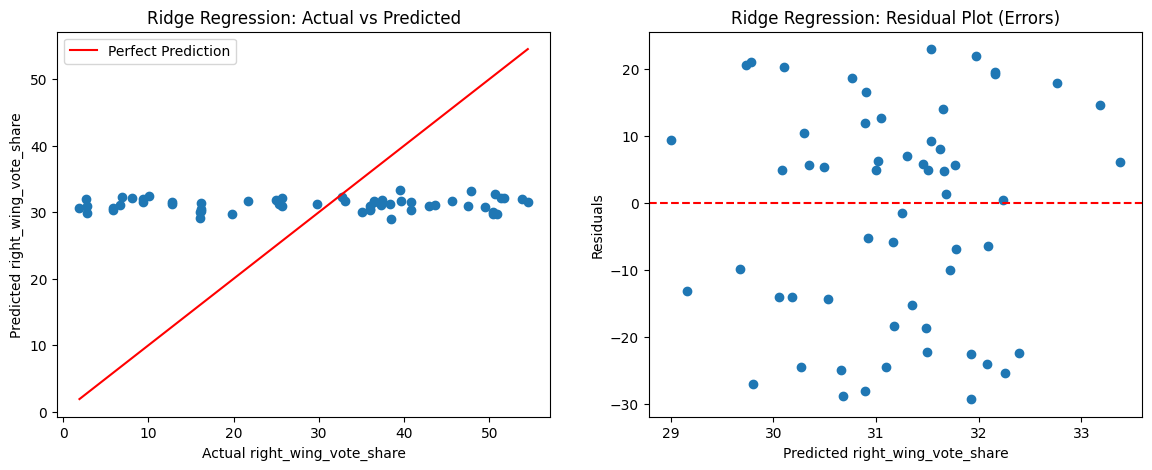

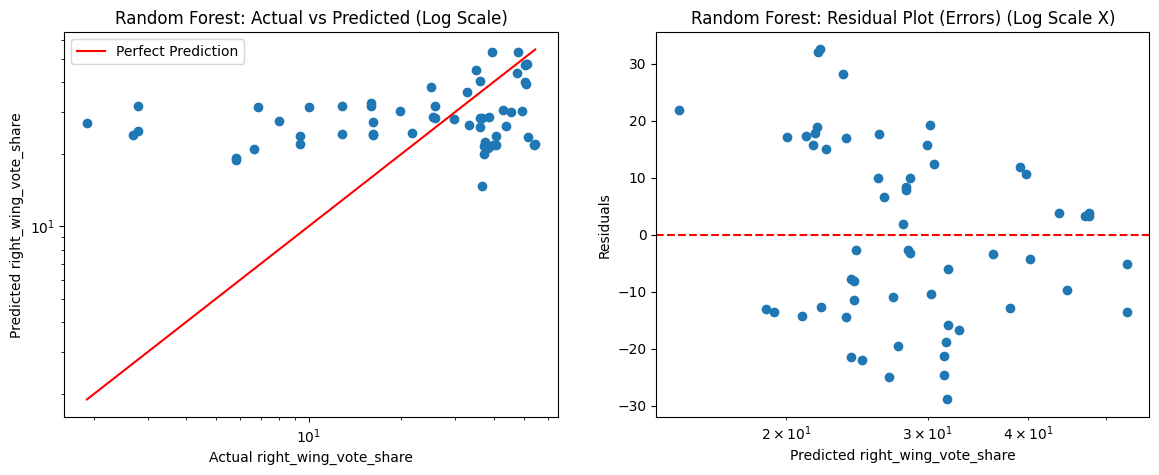

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# =========================
# CONFIG
# =========================
FEATURES = ["log_wui", "log_immigration_total"]
TARGET = "right_wing_vote_share"

TEST_SIZE = 0.2
RANDOM_STATE = 42

# =========================
# DATA
# =========================
DATA_PATH = "data_processed.csv"
data = pd.read_csv(DATA_PATH)

# Keep only needed cols and drop NaNs
data = data[FEATURES + [TARGET]].dropna()

X = data[FEATURES]
y = data[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# =========================
# MODELS
# =========================
models = {
    "Linear Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    "Ridge Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0))
    ]),
    "Random Forest": RandomForestRegressor(
        n_estimators=400,
        max_depth=6,
        random_state=RANDOM_STATE
    )
}

# =========================
# PLOTTING FUNCTION
# =========================
def plot_model_pair(ax_left, ax_right, y_true, y_pred, title_prefix,
                    x_log=False, y_log=False, resid_x_log=False):
    # --- Actual vs Predicted ---
    ax_left.scatter(y_true, y_pred)

    # perfect prediction line
    minv = min(y_true.min(), y_pred.min())
    maxv = max(y_true.max(), y_pred.max())
    ax_left.plot([minv, maxv], [minv, maxv], color= "red", linestyle="-", label="Perfect Prediction")
    ax_left.set_title(f"{title_prefix}: Actual vs Predicted" + (" (Log Scale)" if (x_log or y_log) else ""))
    ax_left.set_xlabel(f"Actual {TARGET}")
    ax_left.set_ylabel(f"Predicted {TARGET}")
    ax_left.legend()

    if x_log:
        ax_left.set_xscale("log")
    if y_log:
        ax_left.set_yscale("log")

    # --- Residual plot ---
    residuals = y_true - y_pred
    ax_right.scatter(y_pred, residuals)
    ax_right.axhline(0, color= "red",linestyle="--")
    ax_right.set_title(f"{title_prefix}: Residual Plot (Errors)" + (" (Log Scale X)" if resid_x_log else ""))
    ax_right.set_xlabel(f"Predicted {TARGET}")
    ax_right.set_ylabel("Residuals")

    if resid_x_log:
        ax_right.set_xscale("log")


# =========================
# RUN + PRINT METRICS + PLOTS
# =========================
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({"Model": name, "RMSE": rmse, "R2": r2})

    # Print model + metrics
    print("\n" + "#" * 60)
    print(f"### DETAILED ANALYSIS: {name.upper()} ###")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    # Print coefficients for linear-ish models
    if name in ["Linear Regression", "Ridge Regression"]:
        # pipeline -> last step coefficients
        coef = model.named_steps["model"].coef_
        intercept = model.named_steps["model"].intercept_
        coef_df = pd.DataFrame({"Feature": FEATURES, "Coefficient": coef})
        print("\nCoefficients:")
        print(coef_df.to_string(index=False))
        print(f"Intercept: {intercept:.4f}")

    # --- Create side-by-side plots (like your SS) ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    if name == "Random Forest":
        # mimic your SS: log scale for Actual vs Predicted + log scale X for residual plot
        plot_model_pair(
            axes[0], axes[1],
            y_true=y_test.to_numpy(),
            y_pred=y_pred,
            title_prefix=name,
            x_log=True, y_log=True,
            resid_x_log=True
        )
    else:
        plot_model_pair(
            axes[0], axes[1],
            y_true=y_test.to_numpy(),
            y_pred=y_pred,
            title_prefix=name,
            x_log=False, y_log=False,
            resid_x_log=False
        )

    plt
